#### Import field data

In [1]:
from initialisation import *

# Import empirical vegetation density
Vs = {landscape: matrix_to_dict(np.loadtxt('field-data/'+landscape+'/vegetation.asc', skiprows=6)[1:-1,1:-1]) for landscape in ['shrubland', 'grassland']}

# Import empirical topography
Ts = {landscape: matrix_to_dict(np.loadtxt('field-data/'+landscape+'/topography.asc', skiprows=6)[1:-1,1:-1]) for landscape in ['shrubland', 'grassland']}

# Import MAHLERAN sediment functional connectivity
FC_star = {landscape: matrix_to_dict(np.loadtxt('MAHLERAN-data/'+landscape+'/sediment-connectivity.asc', skiprows=6)[1:-1,1:-1]) for landscape in ['shrubland', 'grassland']}


#### Initialise lattice

In [ ]:
# Create baseline 2D lattice, empirical field data default width=20 and height=60
G_baseline, bulk_nodes = generate_baseline_lattice(20,60)
S, current, branches, new_active, size = declare_simulation_variables(G_baseline)

# Adapt G to shrubland empirical data, assuming probabilistic and deterministic dynamics
G_landscape, propagation_probability, edge_slope, C, SC = {}, {}, {}, {}, {}
for landscape in ['shrubland', 'grassland']:
    G_landscape[landscape], propagation_probability[landscape], edge_slope[landscape] = adapt_lattice_to_topography(G_baseline, Ts[landscape])
    C[landscape], SC[landscape] = {}, {}
    for dynamics in ['probabilistic', 'deterministic']:
        print('Preparing node coupling dictionary for '+landscape+' assuming '+dynamics+' dynamics...')
        C[landscape][dynamics] = create_node_coupling_dictionary(G_landscape[landscape][dynamics])
        print('Computing SC on '+landscape+' assuming '+dynamics+' dynamics...')
        SC[landscape][dynamics] = compute_SC(G_landscape[landscape][dynamics], edge_slope[landscape][dynamics])


Preparing node coupling dictionary for shrubland assuming probabilistic dynamics...
Computing SC on shrubland assuming probabilistic dynamics...
Preparing node coupling dictionary for shrubland assuming deterministic dynamics...
Computing SC on shrubland assuming deterministic dynamics...
Preparing node coupling dictionary for grassland assuming probabilistic dynamics...
Computing SC on grassland assuming probabilistic dynamics...
Preparing node coupling dictionary for grassland assuming deterministic dynamics...
Computing SC on grassland assuming deterministic dynamics...


#### Visualisation

Congratulations! You have selected deterministic dynamics on grassland.


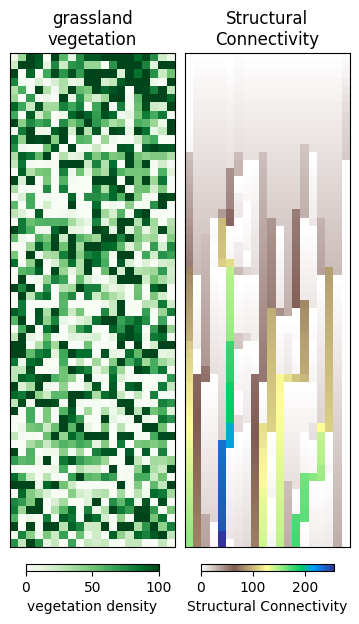

In [3]:
landscape = int(input('Select the emprical landscape (boolean integer) you want to visualise: 0 for "shrubland", or 1 for "grassland".'))
dynamics = int(input('Select the type of SC dynamics (boolean integer): 0 for "probabilistic routing", or 1 for "deterministic routing"'))

dynamics = 'probabilistic' if dynamics==0 else 'deterministic'
landscape = 'shrubland' if dynamics==0 else 'grassland'
print('Congratulations! You have selected '+dynamics+' dynamics on '+landscape+'.')

fig, ax = plt.subplots(1,2, figsize=(3.5,6), constrained_layout=True)
p = ax[0].imshow(dict_to_mat(Vs[landscape]), cmap='Greens'), ax[1].imshow(dict_to_mat(SC[landscape][dynamics]), cmap='terrain_r')
_ = [ax[k].set_xticks([]) for k in range(2)]
_ = [ax[k].set_yticks([]) for k in range(2)]
cbar = [fig.colorbar(p[k], ax=ax[k], orientation='horizontal', shrink=.8, pad=.03) for k in range(2)]
_ = ax[0].set_title(landscape+'\nvegetation')
_ = ax[1].set_title('Structural\nConnectivity')
cbar[0].set_label('vegetation density')
cbar[1].set_label('Structural Connectivity')
plt.show()

#### Simulation run

In [4]:
landscape = int(input('Select the emprical landscape (boolean integer): 0 for "shrubland", or 1 for "grassland".'))
dynamics = int(input('Select the type of dynamics (boolean integer): 0 for "probabilistic routing", or 1 for "deterministic routing"'))
nb_runs = int(input('Enter the number of sandpile simulations (integer):'))
nb_steps = (int(input('Enter the number of steps per simulation (integer):'))//100)*100

dynamics = 'probabilistic' if dynamics==0 else 'deterministic'
landscape = 'shrubland' if dynamics==0 else 'grassland'
print('Congratulations! You have selected '+str(nb_runs)+' runs of '+str(nb_steps)+' steps of '+dynamics+' dynamics on '+landscape+'.')


Congratulations! You have selected 1 runs of 100000 steps of deterministic dynamics on grassland.


In [26]:
G_land, edge_slope, propagation, C = pickle.load(open('field-data/'+landscape+'/simulation_tools/'+dynamics+'/propagation_probabilities.txt','rb')), pickle.load(open('field-data/'+landscape+'/simulation_tools/'+dynamics+'/empirical_lattice.txt','rb')), pickle.load(open('field-data/'+landscape+'/simulation_tools/'+dynamics+'/edge_slope.txt','rb')), pickle.load(open('field-data/'+landscape+'/simulation_tools/'+dynamics+'/coupling.txt','rb'))
SC = compute_SC(G, edge_slope)

step_slice = int(nb_steps/100)
SC_FCt, Sizes = np.zeros((nb_runs, 100), float), np.zeros(nb_runs, list)
for run in range(nb_runs):
    print('Run n°'+str(run+1)+'...')
    S, current_av, branches, active, Sizes[run] = declare_simulation_variables(G_land)
    C_run = deepcopy(C)
    for step in range(nb_steps+1):
        S, C_run, current_av, branches, active, Sizes[run] = sandpile_simulation_step(G_land, Vs[landscape], propagation, S, C_run, current_av, branches, active, Sizes[run], bulk_nodes)
        if step % step_slice == 0 and step>0:
            FC = compute_FC(C_run)
            SC_FCt[run, int(step/step_slice-1)] = SCFC(SC[landscape][dynamics], FC, bulk_nodes)

print('After '+str(nb_runs)+' runs of '+str(nb_steps)+' steps,')
print('Average SC-FC correlation: '+str(round(np.mean([SC_FCt[run,-1] for run in range(nb_runs)]),2)))


EOFError: Ran out of input

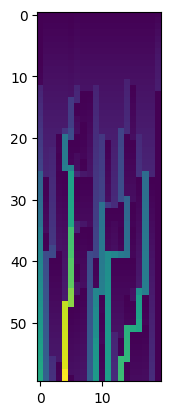

In [7]:

plt.imshow(dict_to_mat(SC[landscape][dynamics]))

#### Visualisation

In [2]:
step_arange = np.arange(1, step_slice, nb_steps+1)
SCFC_avg = np.array([np.mean([SC_FCt[run,k] for run in range(nb_runs)]) for k in range(100)])
SCFC_std = np.array([np.std([SC_FCt[run,k] for run in range(nb_runs)]) for k in range(100)])

plt.fill_between(step_arange, SCFC_avg-SCFC_std, SCFC_avg+SCFC_std, alpha=.6)

NameError: name 'step_slice' is not defined

In [ ]:
def sandpile(g, v, ep, state, coupling, current_av, branches, old_active, size, not_sinks):# exit_,
    new_active, unstable = [], [node for node in old_active if state[node] >= g.out_degree(node)]
    if len(unstable):
        for node1 in unstable:
            nb_partcl, state[node1] = state[node1], 0
            if len(current_av) == 0:
                current_av[node1] = 0
            if g.out_degree(node1):
                spreading_scheme = Counter(random.choices(list(g.successors(node1)), weights=ep[(node1)], k=nb_partcl))
                for node2 in spreading_scheme:
                    state[node2] += np.sum(np.random.rand(spreading_scheme[node2]) > v[node2]/2)
                    current_av[node2] = current_av[node1]+1
                    if node2 not in branches:
                        branches[node2] = [node1]
                    elif node1 not in branches[node2]:
                        branches[node2].append(node1)
                    # record all the previous sources of the new incident node (at least, from a new path)
                    origin, all_sources, sources = list(current_av.keys())[0], [node1], [node1]
                    while origin not in sources:
                        new_sources = []
                        for source in sources:
                            new_sources += branches[source]
                        new_sources = list(set(new_sources))
                        all_sources += new_sources
                        sources = new_sources
                    # record couplings between new incident node and all its previous sources
                    for source in all_sources: # collapse 'all_sources' to avoid redundance of nodes
                        coupling[source][node2].append(current_av[node2]-current_av[source])
                    if node2 not in new_active:
                        new_active.append(node2)
            #else:
            #    exit_ += nb_partcl
    else:
        if len(current_av):
            size.append(len(current_av)-1)
        current_av, branches = {}, {}
        node2 = random.choice(not_sinks)
        #print(node2, v[node2], type(node2), type(v[node2]))
        #if v[node2] == 0:
        if random.random() > v[node2]/2:
            state[node2] += 1
            new_active.append(node2)
    return state, coupling, current_av, branches, new_active, size#, exit_




In [14]:
with open('Gtest.txt','wb') as f:
    pickle.dump(G_prob, f)

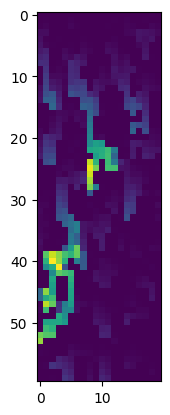

In [13]:
plt.imshow(dict_to_mat(compute_FC(C)))
import pickle
with open('Ctest.txt','wb') as f:
    pickle.dump(C,f)


{(0, 0): 0, (0, 1): 0, (0, 2): 0.25, (0, 3): 0, (0, 4): 0, (0, 5): 0.0, (0, 6): 0, (0, 7): 0.0, (0, 8): 1.1388888888888888, (0, 9): 1.551020408163265, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0.1875, (0, 14): 0.609375, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0.6666666666666666, (0, 19): 0, (0, 20): 0, (0, 21): 0, (0, 22): 0, (0, 23): 0.0, (0, 24): 0.25, (0, 25): 0.6666666666666666, (0, 26): 0, (0, 27): 0, (0, 28): 0.0, (0, 29): 0.0, (0, 30): 0, (0, 31): 0, (0, 32): 0, (0, 33): 0, (0, 34): 0, (0, 35): 0, (0, 36): 0, (0, 37): 0, (0, 38): 1.3599999999999999, (0, 39): 1.8055555555555554, (0, 40): 0.0, (0, 41): 0, (0, 42): 0, (0, 43): 0.2222222222222222, (0, 44): 0, (0, 45): 0, (0, 46): 0, (0, 47): 0, (0, 48): 0, (0, 49): 0, (0, 50): 0.0, (0, 51): 0, (0, 52): 7.734375, (0, 53): 9.3, (0, 54): 0.6666666666666666, (0, 55): 0, (0, 56): 0, (0, 57): 0, (0, 58): 0, (0, 59): 0, (1, 0): 0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 0, (1, 4): 0, (1, 5): 0.2222222222222222, (1, 6): 0.0, (1, 7): 0.25,

NameError: name 'SC' is not defined

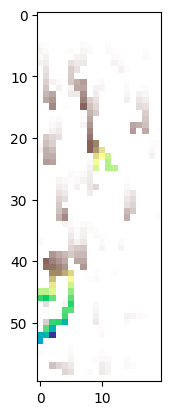

In [11]:
def compute_FC(coupling):
    '''
    Compute FC
    Input
        coupling: tracked particle exchange (list of integers) between a
    '''
    fc = {i:0 for i in coupling}
    for i in coupling:
        fci = sum(coupling[i].values(),[])
        if len(fci):
            fc[i] += np.var(fci)
        else:
            fc[i] = 0
    return fc

def compute_FC2(c):
    fci, fc = {i:[] for i in c}, {}
    for i in c:
        for j in c[i]:
            fci[j] += c[i][j]
    for i in c:
        fc[i] = 0
        if len(fci[i]):
            fc[i] = np.var(fci[i])
    return fc

FC = compute_FC(C_run)
print(FC)
FC2 = compute_FC2(C_run)
print(FC2)
plt.imshow(dict_to_mat(FC2), cmap='terrain_r')
print(SCFC(SC,FC,bulk_nodes))
print(SCFC(SC,FC2,bulk_nodes))



#### Visualisation

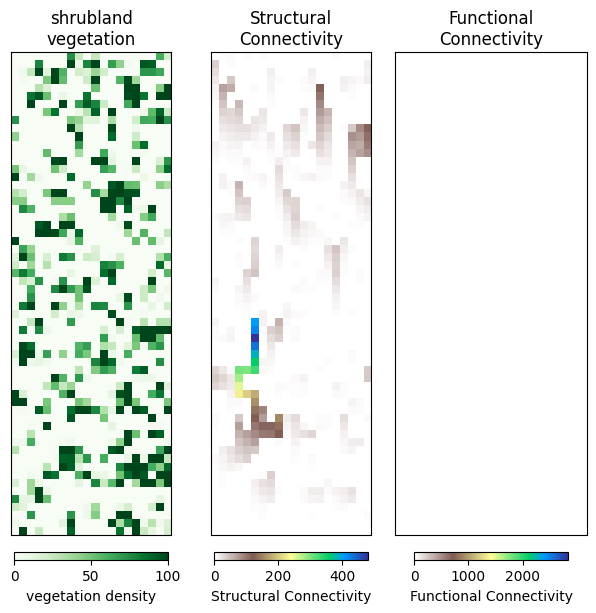

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(6,6), constrained_layout=True)
p = ax[0].imshow(dict_to_mat(Vs['shrub']), cmap='Greens'), ax[1].imshow(dict_to_mat(SC), cmap='terrain_r'), ax[2].imshow(dict_to_mat(FCs[run]), cmap='terrain_r')
_ = [ax[k].set_xticks([]) for k in range(3)]
_ = [ax[k].set_yticks([]) for k in range(3)]
cbar = [fig.colorbar(p[k], ax=ax[k], orientation='horizontal', shrink=.8, pad=.03) for k in range(3)]
_ = ax[0].set_title('shrubland\nvegetation')
_ = ax[1].set_title('Structural\nConnectivity')
_ = ax[2].set_title('Functional\nConnectivity')
cbar[0].set_label('vegetation density')
cbar[1].set_label('Structural Connectivity')
cbar[2].set_label('Functional Connectivity')
plt.show()

In [9]:
print(C_run)

{(0, 0): {}, (0, 1): {(1, 1): [], (2, 1): [], (2, 0): []}, (0, 2): {(1, 2): [1], (2, 2): [2], (2, 1): [], (2, 0): []}, (0, 3): {(0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 4): {(0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 5): {(0, 4): [1, 1, 1, 1, 1, 1, 1, 1, 1], (0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 6): {(0, 5): [], (0, 4): [], (0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 7): {(0, 6): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (0, 5): [], (0, 4): [], (0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 8): {(0, 7): [1, 1], (0, 6): [2, 2],

#### Avalanche size analysis